## Lab 10: LSTM for Hour-Ahead Short-Term Load Forecasting (STLF)
## 🎯 Objectives 
- Develop a **Long Short-Term Memory (LSTM)** network for time-series forecasting.
- Predict electrical load one hour ahead using historical multivariate data.
- Understand how LSTM handles **long-term dependencies** and overcomes the limitations of standard RNNs.
- Prepare and reshape time-series data into supervised learning format suitable for LSTM input.
- Train the LSTM model and evaluate it using metrics like **MAE**, **RMSE**, and **MAPE**.
- Apply **callbacks** such as EarlyStopping and ModelCheckpoint to optimize training.
- Compare the performance of LSTM with other models like Simple RNN and 1D CNN in the context of STLF.


## 📂 Set Working Directory

In [2]:
import os
os.chdir(r'C:\Users\PMLS\ML\lab10')

## 📦 Required Imports

This project uses standard ML libraries along with custom utility modules for time-series forecasting.

```python
# Core Libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, time, pickle, glob, h5py

# Model Development
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, SimpleRNN, Conv1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPooling1D, GlobalMaxPooling1D, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import tensorflow.keras.backend as K

# Custom Utilities & Callbacks
from timeseires.utils import *
from timeseires.callbacks import EpochCheckpoint, TrainingMonitor


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

## 🔧 Model Configuration

In [4]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

## 🧠 LSTM Model Architecture


In [5]:
def create_lstm():
    input_data = Input(shape=(time_steps, num_features))
    lstm_layer1 = LSTM(8, return_sequences=True)(input_data)
    lstm_layer2 = LSTM(20)(lstm_layer1)
    x = Flatten()(lstm_layer2)
    output_data = Dense(1)(x)
    model = Model(input_data, output_data)
    return model

In [6]:
model1 = create_lstm()
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 21)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 24, 8)               │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20)                  │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301 (12.89 KB)

 Trainable params: 3,301 (12.89 KB)

 Non-trainable params: 0 (0.00 B)

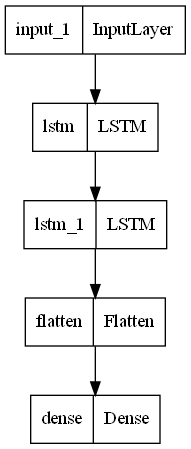

In [6]:
tensorflow.keras.utils.plot_model(model1 )

### 💾 File Paths for Checkpoints and Training History

Defines paths to save:

- Model checkpoints after each epoch
- Training history plot (`history.png`)
- Training history in JSON format (`history.json`)


In [7]:
checkpoints = r'C:\Users\PMLS\ML\lab10\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'C:\Users\PMLS\ML\lab10\checkpoint'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

### 📉 Callbacks for Checkpointing and Training Monitoring


In [8]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

### 🚀 Model Compilation or Checkpoint Loading


In [9]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =create_lstm()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


### 📥 Loading Dataset and Scaler for Training, Validation, and Testing


In [13]:
import os
path_dataset ="C:\\Users\\PMLS\ML\\lab10"
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

C:\Users\PMLS\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

### 🔧 Time-Series Input Configuration


In [14]:
time_steps=24
num_features=21

### 🧪 Preparing Input Data Using Univariate Multi-Step Function


In [15]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.5434198379516602 sec


### 🏋️ Model Training with Validation and Callbacks


In [17]:
epochs = 60
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/60
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - mae: 0.0066 - mape: 41.7861 
Epoch 1: val_loss did not improve from 0.00623
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.0066 - mae: 0.0066 - mape: 41.8006 - val_loss: 0.0066 - val_mae: 0.0066 - val_mape: 2.7208
Epoch 2/60
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - mae: 0.0066 - mape: 62.9433 
Epoch 2: val_loss did not improve from 0.00623
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 0.0066 - mae: 0.0066 - mape: 63.0084 - val_loss: 0.0064 - val_mae: 0.0064 - val_mape: 2.6355
Epoch 3/60
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - mae: 0.0066 - mape: 41.0209 
Epoch 3: val_loss did not improve from 0.00623
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 0.0066 - mae: 0.0066 - mape: 41.0219 - val_loss: 0.0064 - val_mae: 0.0064 - val_mape: 2.6496
Epoch 4/60
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - mae: 0.0066 - mape: 34.9814
Epoch 4: val_loss 

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.0065 - mae: 0.0065 - mape: 5.2017 - val_loss: 0.0059 - val_mae: 0.0059 - val_mape: 2.5814
Epoch 7/60
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - mae: 0.0065 - mape: 48.9517 
Epoch 7: val_loss did not improve from 0.00595
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.0065 - mae: 0.0065 - mape: 48.9328 - val_loss: 0.0065 - val_mae: 0.0065 - val_mape: 2.7326
Epoch 8/60
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - mae: 0.0064 - mape: 29.4734 
Epoch 8: val_loss did not improve from 0.00595
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.0064 - mae: 0.0064 - mape: 29.4536 - val_loss: 0.0065 - val_mae: 0.0065 - val_mape: 2.7408
Epoch 9/60
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - mae: 0.0065 - mape: 25.2703
Epoch 9: val_loss did not improve from 0.00595
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 0.0065 - mae: 0.0065 - mape: 25.2948 - val_loss: 0.0061 - val_mae: 

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.0062 - mae: 0.0062 - mape: 12.1961 - val_loss: 0.0059 - val_mae: 0.0059 - val_mape: 2.4683
Epoch 25/60
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mae: 0.0061 - mape: 60.4086 
Epoch 25: val_loss did not improve from 0.00589
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.0061 - mae: 0.0061 - mape: 60.3757 - val_loss: 0.0061 - val_mae: 0.0061 - val_mape: 2.5431
Epoch 26/60
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mae: 0.0062 - mape: 58.0860  
Epoch 26: val_loss did not improve from 0.00589
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0062 - mae: 0.0062 - mape: 58.0846 - val_loss: 0.0063 - val_mae: 0.0063 - val_mape: 2.7941
Epoch 27/60
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - mae: 0.0061 - mape: 73.5645
Epoch 27: val_loss did not improve from 0.00589
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.0061 - mae: 0.0061 - mape: 73.5124 - val_loss: 0.0062 - val

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.0061 - mae: 0.0061 - mape: 261.0060 - val_loss: 0.0057 - val_mae: 0.0057 - val_mape: 2.3696
Epoch 33/60
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - mae: 0.0061 - mape: 605.0961  
Epoch 33: val_loss did not improve from 0.00570
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0061 - mae: 0.0061 - mape: 604.3890 - val_loss: 0.0061 - val_mae: 0.0061 - val_mape: 2.5775
Epoch 34/60
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - mae: 0.0061 - mape: 5.7235 
Epoch 34: val_loss did not improve from 0.00570
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.0061 - mae: 0.0061 - mape: 5.8078 - val_loss: 0.0059 - val_mae: 0.0059 - val_mape: 2.4330
Epoch 35/60
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - mae: 0.0061 - mape: 24.3398 
Epoch 35: val_loss did not improve from 0.00570
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.0061 - mae: 0.0061 - mape: 24.3172 - val_loss: 0.0060 -

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 0.0060 - mae: 0.0060 - mape: 71.7909 - val_loss: 0.0057 - val_mae: 0.0057 - val_mape: 2.4961
Epoch 37/60
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - mae: 0.0060 - mape: 161.7629 
Epoch 37: val_loss did not improve from 0.00567
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0060 - mae: 0.0060 - mape: 161.6589 - val_loss: 0.0075 - val_mae: 0.0075 - val_mape: 3.3423
Epoch 38/60
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - mae: 0.0061 - mape: 31.3194
Epoch 38: val_loss did not improve from 0.00567
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0061 - mae: 0.0061 - mape: 31.3941 - val_loss: 0.0057 - val_mae: 0.0057 - val_mape: 2.3835
Epoch 39/60
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - mae: 0.0060 - mape: 46.0530 
Epoch 39: val_loss did not improve from 0.00567
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0060 - mae: 0.0060 - mape: 46.0496 - val_loss: 0.0060 - 

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0059 - mae: 0.0059 - mape: 34.7979 - val_loss: 0.0056 - val_mae: 0.0056 - val_mape: 2.4243
Epoch 53/60
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - mae: 0.0060 - mape: 18.3524 
Epoch 53: val_loss did not improve from 0.00556
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 0.0060 - mae: 0.0060 - mape: 18.3357 - val_loss: 0.0058 - val_mae: 0.0058 - val_mape: 2.4033
Epoch 54/60
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - mae: 0.0059 - mape: 45.6553  
Epoch 54: val_loss did not improve from 0.00556
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 0.0059 - mae: 0.0059 - mape: 45.6054 - val_loss: 0.0061 - val_mae: 0.0061 - val_mape: 2.5889
Epoch 55/60
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0060 - mae: 0.0060 - mape: 10.9950
Epoch 55: val_loss did not improve from 0.00556
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 0.0060 - mae: 0.0060 - mape: 11.0323 - val_loss: 0.0060 - v

In [19]:

model = load_model(r'C:\Users\PMLS\ML\lab10\E1-cp-0052-loss0.01.h5', compile=False)

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Mean Absolute Error (MAE): 89.91
Median Absolute Error (MedAE): 71.22
Mean Squared Error (MSE): 14322.38
Root Mean Squared Error (RMSE): 119.68
Mean Absolute Percentage Error (MAPE): 0.61 %
Median Absolute Percentage Error (MDAPE): 0.5 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [25]:
model_path = r'C:\Users\PMLS\ML\lab10\E1-cp-0052-loss0.01.h5'
checkpoints = r'C:\Users\PMLS\ML\lab10\New folder\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
start_epoch = 34

In [26]:
# Load model (no compilation since you're resetting learning rate)
print(f"[INFO] loading model from: {model_path}")
model = load_model(model_path, compile=False)

# Compile the model again with your desired loss/optimizer
opt = Adam(1e-4)  # Reset LR
model.compile(loss='mae', optimizer=opt, metrics=["mae", "mape"])

# Setup callbacks
EpochCheckpoint1 = ModelCheckpoint(
    checkpoints,
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

TrainingMonitor1 = TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

callbacks = [EpochCheckpoint1, TrainingMonitor1]

[INFO] loading model from: C:\Users\PMLS\ML\lab10\E1-cp-0052-loss0.01.h5


In [27]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mae: 0.0054 - mape: 3.6642  
Epoch 1: val_loss improved from inf to 0.00552, saving model to C:\Users\PMLS\ML\lab10\New folder\E2-cp-0001-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 0.0054 - mae: 0.0054 - mape: 3.6674 - val_loss: 0.0055 - val_mae: 0.0055 - val_mape: 2.2987
Epoch 2/10
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mae: 0.0054 - mape: 51.4933  
Epoch 2: val_loss did not improve from 0.00552
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0054 - mae: 0.0054 - mape: 51.4170 - val_loss: 0.0056 - val_mae: 0.0056 - val_mape: 2.2995
Epoch 3/10
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mae: 0.0054 - mape: 8.4545 
Epoch 3: val_loss did not improve from 0.00552
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0054 - mae: 0.0054 - mape: 8.4700 - val_loss: 0.0056 - val_mae: 0.0056 - val_mape: 2.3200
Epoch 4/10
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mae: 0.0053 - mape: 5.2199 
Epoch 4: val_loss did not improve from 0.00552
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0053 - mae: 0.0053 - mape: 5.2203 - val_loss: 0.0057 - val_mae: 0.005

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.0054 - mae: 0.0054 - mape: 34.4539 - val_loss: 0.0055 - val_mae: 0.0055 - val_mape: 2.2498
Epoch 9/10
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - mae: 0.0053 - mape: 2.8679 
Epoch 9: val_loss did not improve from 0.00547
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0053 - mae: 0.0053 - mape: 2.8683 - val_loss: 0.0056 - val_mae: 0.0056 - val_mape: 2.2974
Epoch 10/10
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mae: 0.0053 - mape: 11.5872 
Epoch 10: val_loss did not improve from 0.00547
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0053 - mae: 0.0053 - mape: 11.6222 - val_loss: 0.0055 - val_mae: 0.0055 - val_mape: 2.2637


In [29]:

model = load_model(r'C:\Users\PMLS\ML\lab10\New folder\E2-cp-0008-loss0.01.h5', compile=False)

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Mean Absolute Error (MAE): 92.47
Median Absolute Error (MedAE): 72.12
Mean Squared Error (MSE): 15333.47
Root Mean Squared Error (RMSE): 123.83
Mean Absolute Percentage Error (MAPE): 0.63 %
Median Absolute Percentage Error (MDAPE): 0.5 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)
